In [3]:
import requests
import pandas as pd
import numpy as np
import math

subawy18= pd.read_csv("./서울교통공사_1_8호선20241031.csv", encoding="euc-kr")  

subawy9= pd.read_csv("./서울교통공사_1_8호선20241031.csv", encoding="euc-kr")  

In [5]:
subway= pd.read_csv("./서울시 역사마스터 정보.csv", encoding="euc-kr")

In [7]:
subway.head()

,역사_ID,역사명,호선,위도,경도
0,9010,동탄,수도권 광역급행철도,37.20034,127.09569
1,9009,구성,수도권 광역급행철도,37.29913,127.10389
2,9008,성남,수도권 광역급행철도,37.39467,127.12058
3,9007,수서,수도권 광역급행철도,37.48637,127.10161
4,9006,삼성,수도권 광역급행철도,37.50887,127.06324


In [9]:
subway.shape

(786, 5)

In [11]:
cleaned=subway.drop_duplicates(["역사명"])

In [13]:
cleaned[cleaned["역사명"]=="디지털미디어시티"]

,역사_ID,역사명,호선,위도,경도
126,4204,디지털미디어시티,공항철도1호선,37.576646,126.900984


In [15]:
bike_df = pd.read_csv("공공자전거대여소정보_202412.csv", encoding = "euc-kr")

In [17]:
bike_df.head()

,대여소번호,보관소(대여소)명,위도,경도,거치대수
0,301,경복궁역 7번출구 앞,37.575794,126.971451,20
1,302,경복궁역 4번출구 뒤,37.575947,126.974060,12
2,303,광화문역 1번출구 앞,37.571770,126.974663,8
3,305,종로구청 옆,37.572559,126.978332,16
4,307,서울역사박물관 앞,37.570000,126.971100,11


In [19]:
# Haversine 위도,경도로 거리 계산
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  
    pi1, pi2 = math.radians(lat1), math.radians(lat2)
    d_pi = math.radians(lat2 - lat1)
    d_lambda = math.radians(lon2 - lon1)
    a = math.sin(d_pi / 2) ** 2 + math.cos(pi1) * math.cos(pi2) * math.sin(d_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

distance = []

for _, s_row in cleaned.iterrows():
    for _, b_row in bike_df.iterrows():
        dis = haversine(
            s_row['위도'], s_row['경도'],
            b_row['위도'], b_row['경도']
        )
        distance.append({
            '역사명': s_row['역사명'],
            '출구_위도': s_row['위도'],
            '출구_경도': s_row['경도'],
            '대여소번호': b_row['대여소번호'],
            '대여소명': b_row['보관소(대여소)명'],
            '대여소_위도': b_row['위도'],
            '대여소_경도': b_row['경도'],
            '거리(m)': round(dis, 2)
        })


distance_df = pd.DataFrame(distance)

In [20]:
distance_df.head()

,역사명,출구_위도,출구_경도,대여소번호,대여소명,대여소_위도,대여소_경도,거리(m)
0,동탄,37.20034,127.09569,301,경복궁역 7번출구 앞,37.575794,126.971451,43167.42
1,동탄,37.20034,127.09569,302,경복궁역 4번출구 뒤,37.575947,126.974060,43125.81
2,동탄,37.20034,127.09569,303,광화문역 1번출구 앞,37.571770,126.974663,42662.84
3,동탄,37.20034,127.09569,305,종로구청 옆,37.572559,126.978332,42667.89
4,동탄,37.20034,127.09569,307,서울역사박물관 앞,37.570000,126.971100,42552.71


In [21]:
distance_df.shape

(1803432, 8)

In [22]:
df=distance_df[distance_df["거리(m)"]<=500]

In [ ]:
df.to_csv("500m미만_대여소-지하철역.csv")

C:\Users\ITSC\AppData\Local\Temp\ipykernel_7372\3085381981.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_df.groupby("거리구간")[["대여소번호", "역사명"]]
C:\Users\ITSC\AppData\Local\Temp\ipykernel_7372\3085381981.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = filtered_df.groupby("거리구간").size().reset_index(name="총개수")


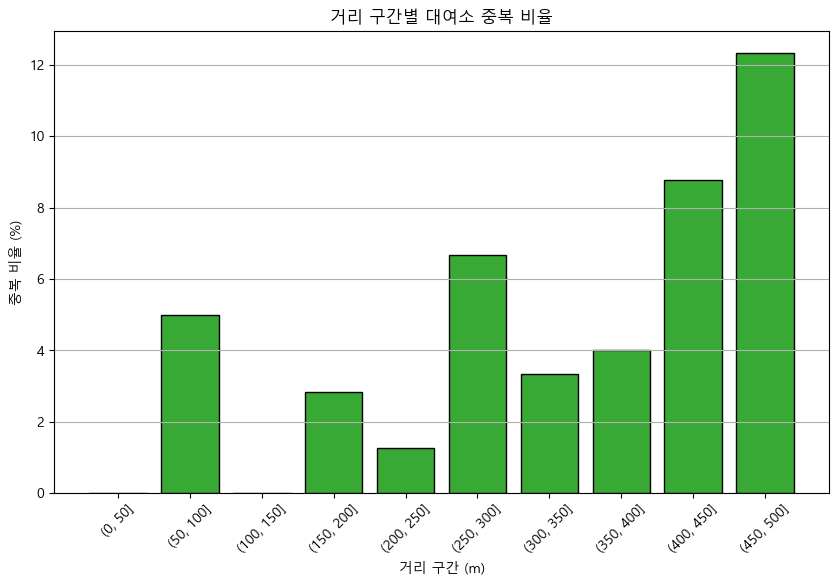

In [32]:
from matplotlib import font_manager, rc
import matplotlib
import matplotlib.pyplot as plt
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname = font_path).get_name()
rc("font", family = font_name)
matplotlib.rcParams["axes.unicode_minus"] = False
#
filtered_df = df[df["거리(m)"] < 500].copy()

filtered_df["거리구간"] = pd.cut(filtered_df["거리(m)"], bins=range(0, 550, 50))

dup_counts = (
    filtered_df.groupby("거리구간")[["대여소번호", "역사명"]]
    .apply(lambda x: x.duplicated(subset=["대여소번호"], keep=False).sum())
    .reset_index(name="중복수")
)

total_counts = filtered_df.groupby("거리구간").size().reset_index(name="총개수")

summary = pd.merge(total_counts, dup_counts, on="거리구간")
summary["중복비율(%)"] = (summary["중복수"] / summary["총개수"] * 100).round(2)


plt.figure(figsize=(10, 6))
plt.bar(summary["거리구간"].astype(str), summary["중복비율(%)"],
       color="#39A935",
       edgecolor="black")
plt.title("거리 구간별 대여소 중복 비율")
plt.xlabel("거리 구간 (m)")
plt.ylabel("중복 비율 (%)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.savefig("거리구간별 대여소 중복 비율.png")
plt.show()


In [20]:
filtered_df = df[df["거리(m)"] < 350].copy()


filtered_df

,역사명,출구_위도,출구_경도,대여소번호,대여소명,대여소_위도,대여소_경도,거리(m)
10558,수서,37.486370,127.10161,2375,수서역 1번출구 앞,37.487350,127.100998,121.67
10559,수서,37.486370,127.10161,2376,수서역 6번출구 앞,37.486778,127.100517,106.56
10560,수서,37.486370,127.10161,2377,수서역 5번출구,37.487350,127.102325,125.98
13273,삼성,37.508870,127.06324,2316,삼성역 8번출구,37.509575,127.063408,79.77
13279,삼성,37.508870,127.06324,2322,삼성역 3번 출구,37.508091,127.063103,87.47
...,...,...,...,...,...,...,...,...
1800872,남영,37.541021,126.97130,828,숙대입구역 8번,37.544079,126.972000,345.57
1800877,남영,37.541021,126.97130,835,남영역 건너편,37.541981,126.971542,108.84
1800925,남영,37.541021,126.97130,4625,용산공원갤러리앞,37.539322,126.973190,251.94
1800936,남영,37.541021,126.97130,4641,아메리칸센터,37.540390,126.973495,205.90


In [21]:
conflict =filtered_df.groupby('대여소번호')['역사명'].nunique().reset_index()
conflict_ids = conflict[conflict['역사명'] > 1]['대여소번호']
result = df[df['대여소번호'].isin(conflict_ids)]
result_sorted = result.sort_values(by='대여소번호').reset_index(drop=True)
result_sorted


,역사명,출구_위도,출구_경도,대여소번호,대여소명,대여소_위도,대여소_경도,거리(m)
0,광흥창(서강),37.547456,126.931993,121,마포소방서 앞,37.549767,126.933174,277.22
1,서강대,37.551881,126.935711,121,마포소방서 앞,37.549767,126.933174,324.50
2,서강대,37.551881,126.935711,127,현대벤처빌 앞,37.553520,126.936951,212.52
3,신촌,37.555134,126.936893,127,현대벤처빌 앞,37.553520,126.936951,179.52
4,신촌,37.555134,126.936893,130,신촌역(2호선) 7번출구 앞,37.554859,126.936157,71.70
...,...,...,...,...,...,...,...,...
82,삼성(무역센터),37.508844,127.063160,4901,KT&G타워 옆(상상마당 대치아트홀),37.506874,127.064735,259.41
83,삼성,37.508870,127.063240,4905,강남경찰서,37.509720,127.066795,327.54
84,삼성(무역센터),37.508844,127.063160,4905,강남경찰서,37.509720,127.066795,335.13
85,삼성,37.508870,127.063240,4906,섬유센터 앞,37.507671,127.060173,301.58


In [23]:
filtered_df.to_csv("350m미만_대여소-지하철역.csv")